In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# make plots look a bit nicer
sns.set_theme(style="whitegrid")

df = pd.read_excel("travel_emails.xlsx")

# Preview first few rows
df.head()

,first_name,last_name,company_name,email
0,NaN,NaN,atoai,arshdeepanand@gmail.com
1,NaN,NaN,atoai,milind@countrysideindia.com
2,NaN,NaN,atoai,info@junoonadventure.in
3,NaN,NaN,atoai,east_chapter@atoai.org
4,NaN,NaN,atoai,north_chapter@atoai.org


In [21]:
# Basic shape (total records) and column names
total_records = len(df)
columns = df.columns.tolist()
total_records, columns

(1129, ['first_name', 'last_name', 'company_name', 'email'])

In [24]:
# Derive generic vs non-generic (enhanced rule including company/domain match)
import re

generic_prefixes = ('info','support','admin','hello')

def classify_generic(row):
    email = str(row['email']).strip()
    company = str(row['company_name']).strip()
    first = str(row['first_name']).strip()
    last = str(row['last_name']).strip()

    # Basic guards
    if '@' not in email:
        return 'non-generic'

    local = email.split('@')[0].lower()
    domain_root = email.split('@')[1].split('.')[0].lower()

    # Normalization helper: remove non-alphanumeric to compare fairly
    norm = lambda s: re.sub(r'[^a-z0-9]', '', s.lower())
    company_norm = norm(company)
    domain_norm = norm(domain_root)
    first_norm = norm(first)
    last_norm = norm(last)

    # prefix-based generic
    prefix_generic = any(local.startswith(p) for p in generic_prefixes)

    # domain/company match 
    # Match if equal OR one contained in the other
    company_domain_match = (
        company_norm and domain_norm and
        (company_norm == domain_norm or
         company_norm in domain_norm or
         domain_norm in company_norm)
    )

    # if local part looks like a personal address 
    personal_like = (
        first_norm and last_norm and
        first_norm in local and
        last_norm in local
    )

    # Final decision logic
    if prefix_generic:
        return 'generic'
    if company_domain_match and not personal_like:
        # Treat functional/local names (e.g., projectzone@company.com) as generic
        return 'generic'
    return 'non-generic'

# Apply classification 
email_type = df.apply(classify_generic, axis=1)

# Counts & percentages (same downstream usage as before)
email_type_counts = email_type.value_counts()
email_type_pct = (email_type_counts / len(df) * 100).round(2)
email_type_counts, email_type_pct

(non-generic    961
 generic        168
 Name: count, dtype: int64,
 non-generic    85.12
 generic        14.88
 Name: count, dtype: float64)

In [26]:
# Most frequent company names (top 10) – clean blanks/NaN
top_companies = (
    df['company_name']
      .astype(str)
      .str.strip()
      .replace({'': pd.NA, 'nan': pd.NA})
      .dropna()
      .value_counts()
      .head(10)
)
top_companies

company_name
Tourism                                  458
Keralatourism                            391
iato                                     158
Gujarattourism                            48
atoai                                     43
india tourism development corporation     16
Exploreworldtourism                        4
Travellshop                                3
Traveldreamz                               2
Incredibleindia                            2
Name: count, dtype: int64

In [11]:
# Most frequent company names (exclude NaN)
top_companies = (
    df['company_name']
      .dropna()
      .str.strip()
      .replace('', pd.NA)
      .dropna()
      .value_counts()
      .head(10)
)
top_companies

company_name
Tourism                                  458
Keralatourism                            391
iato                                     158
Gujarattourism                            48
atoai                                     43
india tourism development corporation     16
Exploreworldtourism                        4
Travellshop                                3
Traveldreamz                               2
Incredibleindia                            2
Name: count, dtype: int64

In [27]:
# Missing value summary (only the four columns)
missing_counts = df.isna().sum()
missing_percent = (missing_counts / total_records * 100).round(2)
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent
})
missing_summary

,missing_count,missing_percent
first_name,278,24.62
last_name,725,64.22
company_name,0,0.00
email,0,0.00


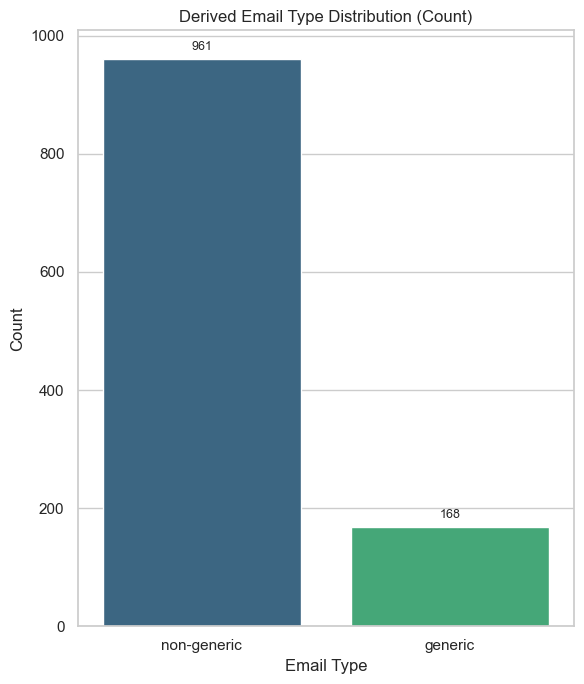

In [34]:
# Visualization 1: Bar chart of derived email_type counts
counts_df = email_type_counts.reset_index()
counts_df.columns = ['email_type','count']

plt.figure(figsize=(6,7))
sns.barplot(
    data=counts_df,
    x='email_type',
    y='count',
    hue='email_type',   
    palette='viridis',
    
)
plt.title("Derived Email Type Distribution (Count)")
plt.xlabel("Email Type")
plt.ylabel("Count")

# Add numeric labels above bars
for i, row in counts_df.iterrows():
    plt.text(
        i,
        row['count'] + counts_df['count'].max()*0.01,  # slight vertical offset
        str(row['count']),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

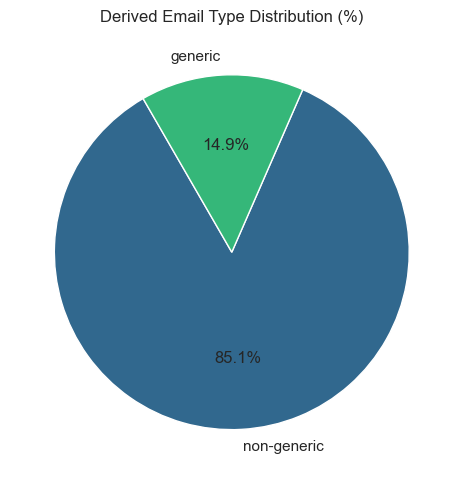

In [35]:
# Visualization 2: Pie chart (percentage share)
plt.figure(figsize=(5,5))
plt.pie(
    email_type_counts.values,
    labels=email_type_counts.index,
    autopct='%1.1f%%',
    startangle=120,
    colors=sns.color_palette("viridis", n_colors=len(email_type_counts))
)
plt.title("Derived Email Type Distribution (%)")
plt.tight_layout()
plt.show()

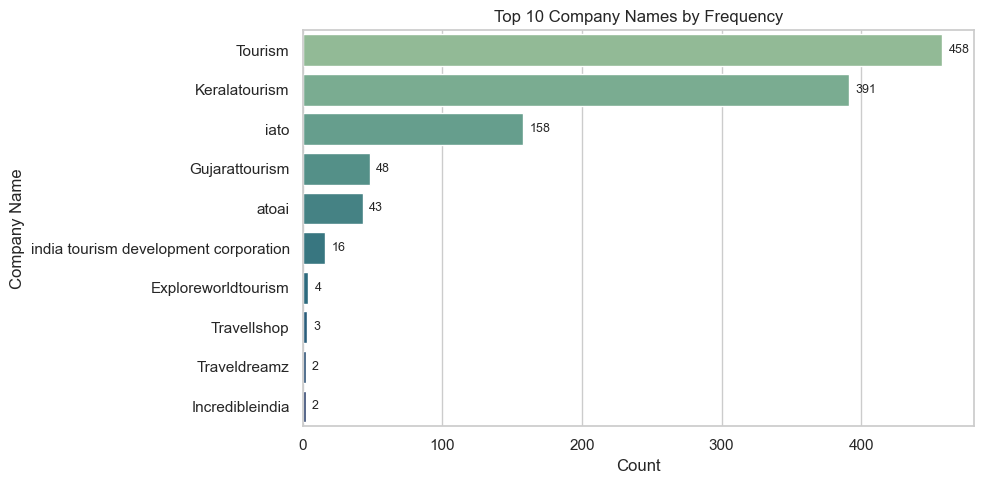

In [38]:
# Top 10 company frequency bar chart 

top_companies_df = top_companies.reset_index()
top_companies_df.columns = ['company_name','count']

plt.figure(figsize=(10,5))
sns.barplot(
    data=top_companies_df,
    y='company_name',
    x='count',
    hue='company_name',
    palette='crest',
    dodge=False,
    legend=False
)
plt.title("Top 10 Company Names by Frequency")
plt.xlabel("Count")
plt.ylabel("Company Name")
for i, row in top_companies_df.iterrows():
    plt.text(
        row['count'] + top_companies_df['count'].max()*0.01,
        i,
        str(row['count']),
        va='center',
        fontsize=9
    )
plt.tight_layout()
plt.show()

In [42]:
# Compact summary dictionary 
summary = {
    "total_records": total_records,
    "generic_count": int(email_type_counts.get('generic', 0)),
    "non_generic_count": int(email_type_counts.get('non-generic', 0))
}
summary["generic %"] = round(summary["generic_count"]/summary["total_records"]*100, 2)
summary["non_generic %"] = round(summary["non_generic_count"]/summary["total_records"]*100, 2)
summary

{'total_records': 1129,
 'generic_count': 168,
 'non_generic_count': 961,
 'generic %': 14.88,
 'non_generic %': 85.12}

Some Insights
1. Personalized (non‑generic) emails dominate, signaling strong direct contact potential.
2. Domain roots usually mirror company names data likely sourced from official corporate domains.
3. Extra generics were found by matching company name to domain.
4. A few companies appear very frequently.
5. Data has alot of missing values in last_name column with 64.22%.
